In [1]:
import argparse
import os
import random
import json
import shutil
import time
import warnings
import torch.cuda as cuda
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from logger import Logger
import os
from torch.nn.modules.loss import _Loss
import VGG_ImageNet as models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import PIL.Image as Image

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device_ids=[3,2]
arch='vgg16_bn_ft'
seed=0
batch_size=64
resume='model_checkpoints/model_best_CUB200_vgg16_bn_ft_v03.pth.tar'
resume1 = 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_A.pth.tar'
resume2 = 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_B.pth.tar'
resume3 = 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_C.pth.tar'
# resume2='model_best_CUB200__vgg16_bn_sd_10_ep300.pth.tar'
dataset='CUB200'
conv_layer=40
topk=[1,3]

In [3]:
def load_checkpoint(resume, model,gpu):
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(gpu)))
        state_dict = checkpoint['state_dict']
        keys = list(state_dict.keys())
        for key in keys:
            if key.find('module'):
                state_dict[key.replace('module.','')] = state_dict.pop(key)

        model.load_state_dict(state_dict)
        print("=> loaded checkpoint '{}' (epoch {} acc1 {})"
              .format(resume, checkpoint['epoch'], checkpoint['best_acc1']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
    del checkpoint, state_dict

In [4]:
cudnn.benchmark = True
if dataset == 'CUB200':
#     net = models.__dict__[arch](num_classes=200).cuda(device_ids[0])
    netA = models.__dict__[arch](num_classes=200).cuda(3)
    netB = models.__dict__[arch](num_classes=200).cuda(3)
    netC = models.__dict__[arch](num_classes=200).cuda(3)

load_checkpoint(resume1, netA, 3)
load_checkpoint(resume2, netB, 3)
load_checkpoint(resume3, netC, 3)

# net.eval()
netA.eval()
netB.eval()
netC.eval()

=> loading checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_A.pth.tar'
=> loaded checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_A.pth.tar' (epoch 206 acc1 69.36486053466797)
=> loading checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_B.pth.tar'
=> loaded checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_B.pth.tar' (epoch 133 acc1 69.5547103881836)
=> loading checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_C.pth.tar'
=> loaded checkpoint 'model_checkpoints/model_best_CUB200_vgg16_bn_ft_full_C.pth.tar' (epoch 155 acc1 68.41560363769531)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [ ]:
del netA,netB,netC

In [3]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

if dataset == 'ilsvrc':
    valdir = '../ILSVRC2012_img_val'
    val_dataset = datasets.ImageFolder(
        valdir, T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ]))
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

    criterion = nn.CrossEntropyLoss()  # .cuda(gpu_id)

    optimizer = torch.optim.SGD(net.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)
elif dataset == 'cifar10':
    transform_test = T.Compose([
        T.ToTensor(),  # [0, 256] -> [0, 1]
        T.Normalize(mean=[0.4914, 0.4822, 0.4465],  # mean
                    std=[0.2470, 0.2435, 0.2616]),  # std
    ])

    val_dataset = datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                   download=True, transform=transform_test)

elif dataset == 'CUB':
    valdir = '../../CUB_bird_binary/val/'

    normalize = T.Normalize(mean=[0.4795, 0.4822, 0.4218],
                            std=[0.2507, 0.2469, 0.2760])

    val_dataset = datasets.ImageFolder(valdir, T.Compose([
        T.Resize(224),
        T.ToTensor(),
        normalize,
    ]))

elif dataset == 'CUB200':
    traindir =  '../../CUB_200_2011/crop/train'
    valdir = '../../CUB_200_2011/crop/test'
    val_dataset = datasets.ImageFolder(
        valdir, T.Compose([
#                 T.RandomResizedCrop(224),
#                 T.RandomHorizontalFlip(),
            T.Resize((224,224)),
#             T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ]))
    train_dataset = datasets.ImageFolder(
        traindir, T.Compose([
#                 T.RandomResizedCrop(224),
#                 T.RandomHorizontalFlip(),
            T.Resize((224,224)),
#             T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ]))
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=6, pin_memory=True)
    # class_map = [[] for i in range(200)]
    # for i in range(len(val_dataset)):
    #     class_map[val_dataset[i][1]].append(i)

## Generate sub_sample

In [5]:
class_map = [[] for i in range(200)]
for i in range(len(train_dataset)):
    class_map[train_dataset[i][1]].append(i)

In [6]:
sub_idx_A_num5 = []
sub_idx_B_num5 = []
sub_idx_A_num10 = []
sub_idx_B_num10 = []
for i in class_map:
    sub_idx_A_num5 += i[:5]
    sub_idx_B_num5 += i[5:10]
    sub_idx_A_num10 += i[:10]
    sub_idx_B_num10 += i[10:20]    

In [7]:
np.save('sub_sampler_CUB200_num5_A.npy', sub_idx_A_num5)
np.save('sub_sampler_CUB200_num5_B.npy', sub_idx_B_num5)
np.save('sub_sampler_CUB200_num10_A.npy', sub_idx_A_num10)
np.save('sub_sampler_CUB200_num10_B.npy', sub_idx_B_num10)

In [11]:
class_len = [len(i) for i in class_map]
print(min(class_len),max(class_len))

29 30


In [10]:
class_map_val = [[] for i in range(200)]
for i in range(len(val_dataset)):
    class_map_val[val_dataset[i][1]].append(i)

In [20]:
sub_idx_M = []
sub_idx_V = []
for i in class_map:
    sub_idx_M += i[:int(len(i)*0.75)]
    sub_idx_V += i[int(len(i)*0.75):]
print(len(sub_idx_M),len(sub_idx_V))

4394 1600


In [21]:
np.save('sub_sampler_CUB200_M.npy',sub_idx_M)
np.save('sub_sampler_CUB200_V.npy',sub_idx_V)

In [12]:
class_len = [len(i) for i in class_map_val]
print(min(class_len),max(class_len))

11 30


## Visualizing

In [4]:
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])
toPIL = T.Compose([denormalize, T.ToPILImage()])

(224, 224)


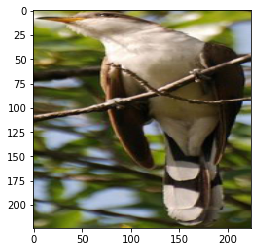

In [5]:
a = toPIL(val_dataset[875][0])
print(a.size)
plt.imshow(a)

In [8]:
i = 875
l = 40

torch.Size([1, 512, 14, 14])


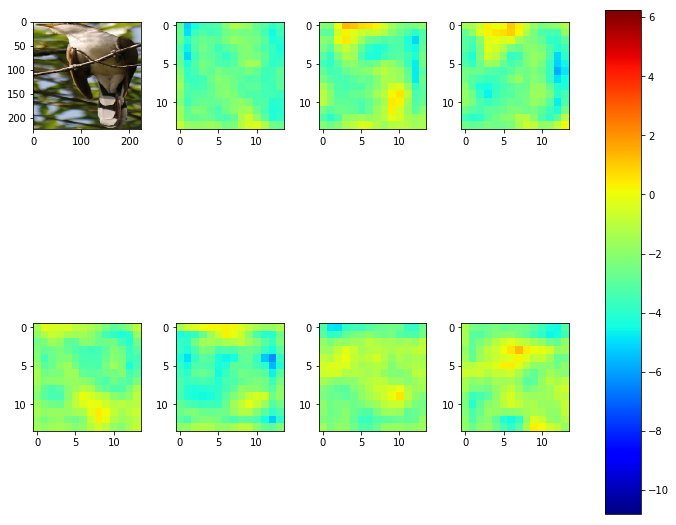

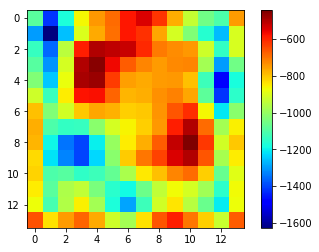

In [13]:

with torch.no_grad():
    input = val_dataset[i][0].unsqueeze(0).cuda(device_ids[0])
    out = netB.features[:l+1](input)
    print(out.shape)
out = out.cpu().squeeze().numpy()
t = [0, 32, 64,96,128,160,192]
lab = range(out[0].shape[0])
cmap = 'jet'
fig1, axes = plt.subplots(2,4,figsize=(10,10))

im0 = axes[0][0].imshow(toPIL(val_dataset[i][0]))

vmin = np.min(out)
vmax = np.max(out)

for k in range(1,8):
    im1 = axes[k//4][k%4].imshow(out[t[k-1]],cmap=cmap, vmin=vmin, vmax=vmax)


fig1.tight_layout()
fig1.subplots_adjust(right=0.8)
cbar_ax1 = fig1.add_axes([0.85, 0.10, 0.05, 0.70])
fig1.colorbar(im1, cax=cbar_ax1)
plt.show()

plt.imshow(out.sum(0), cmap=cmap)
plt.colorbar()
plt.show()

## To see net A,B,C sum of channel

In [8]:
i_list = np.arange(0,len(val_dataset),200)
l = 40

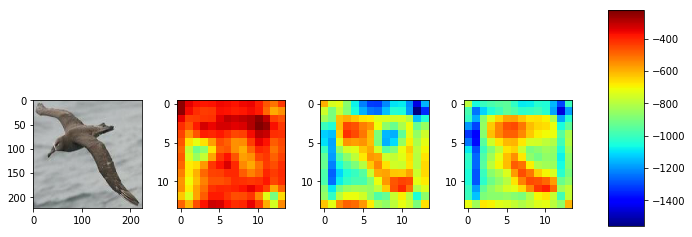

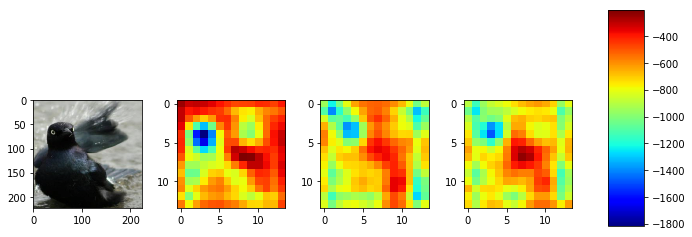

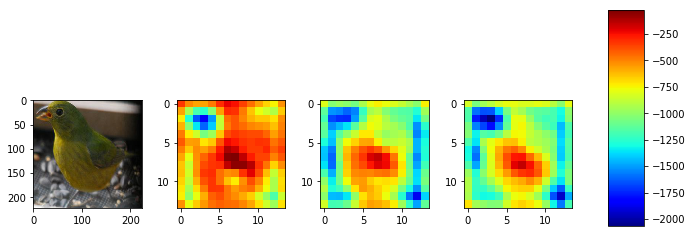

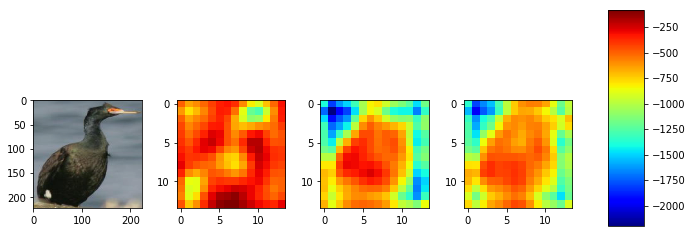

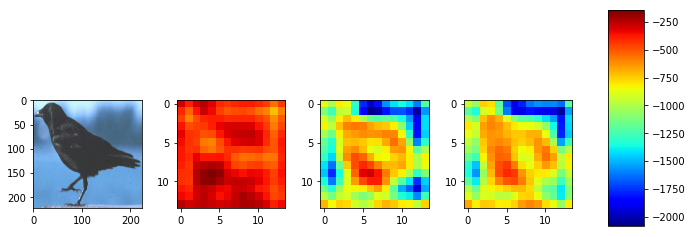

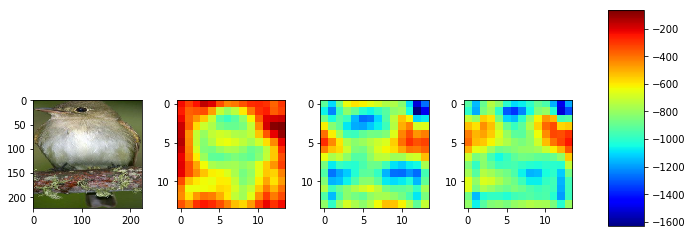

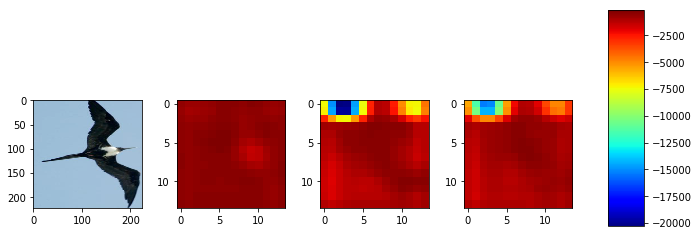

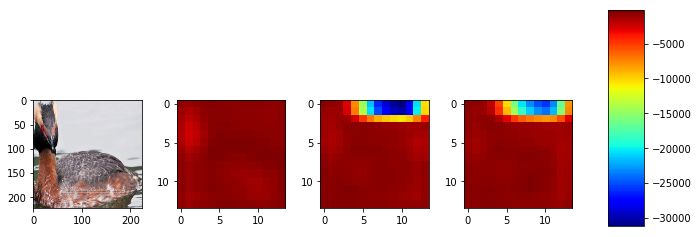

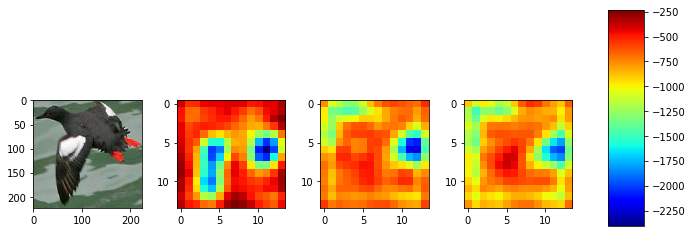

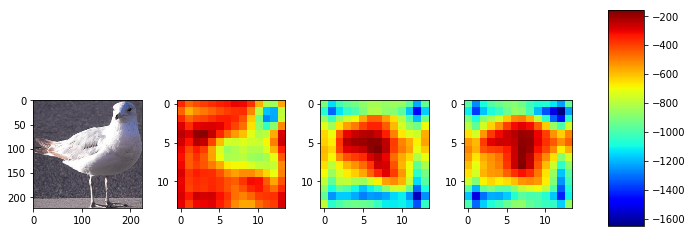

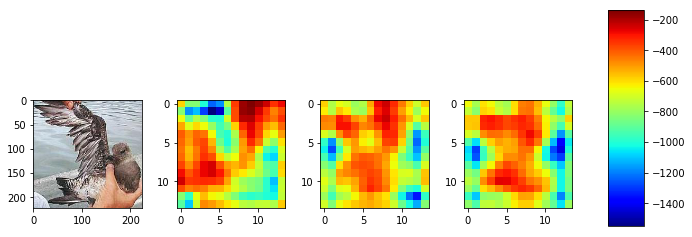

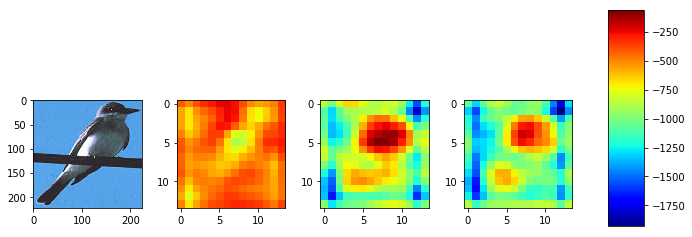

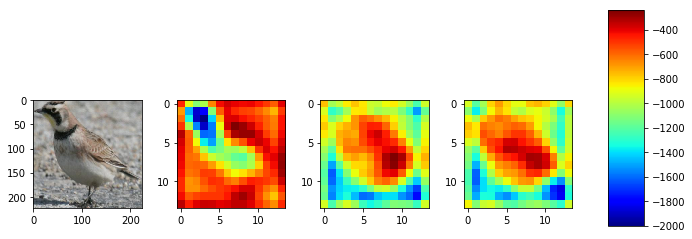

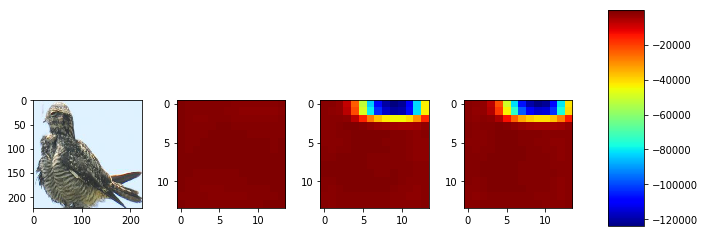

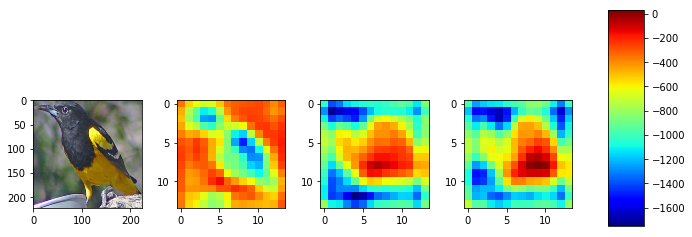

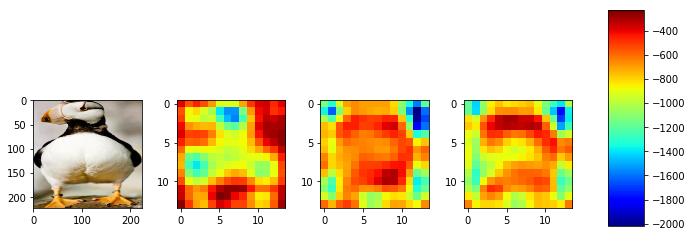

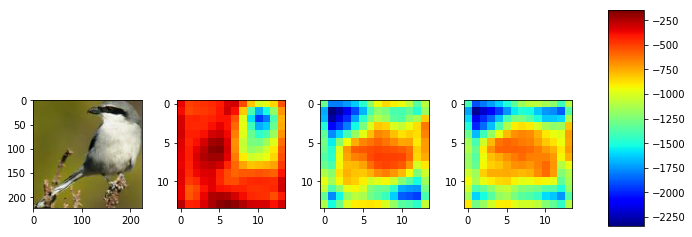

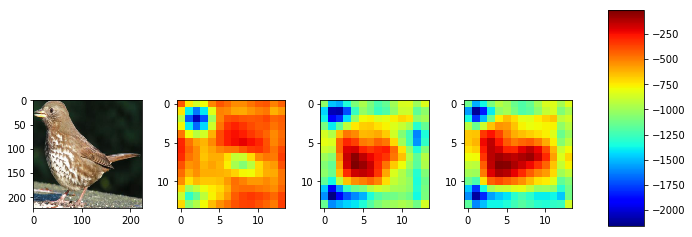

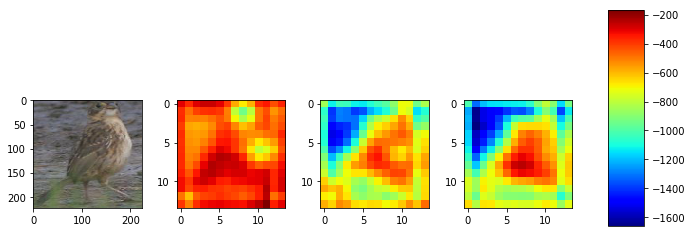

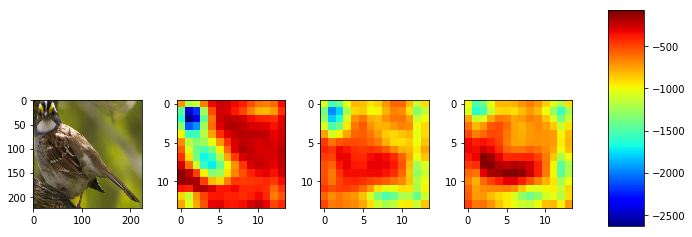

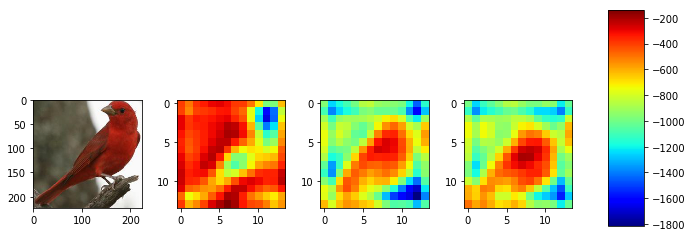

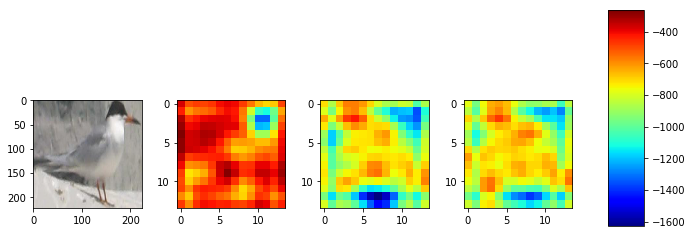

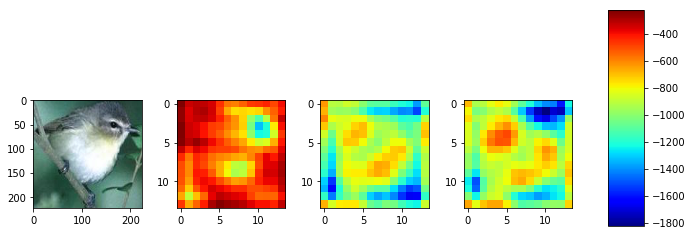

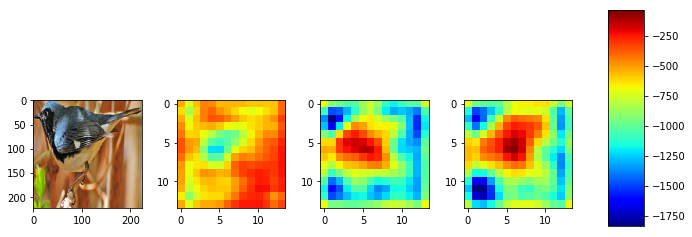

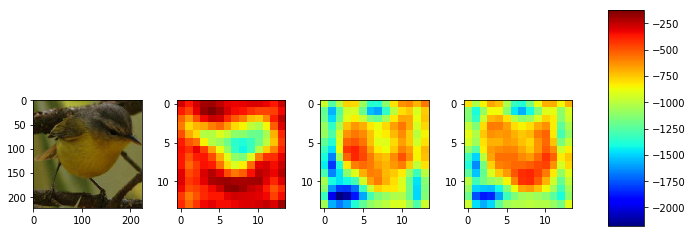

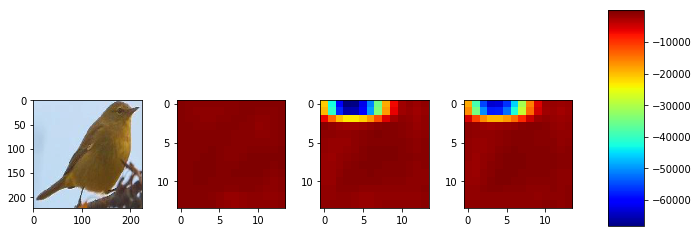

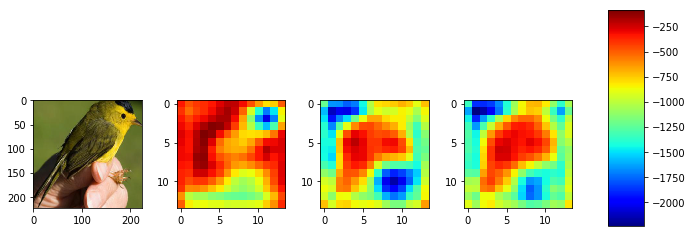

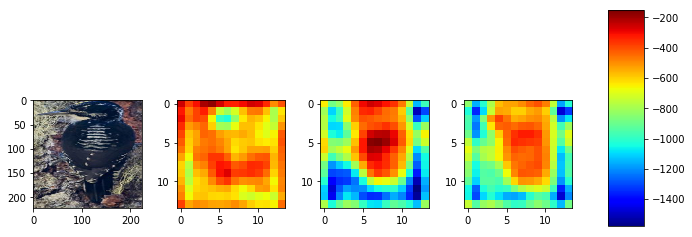

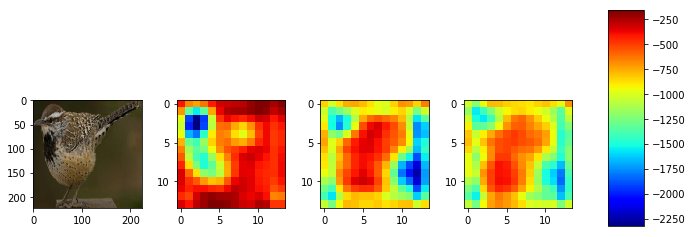

In [12]:
with torch.no_grad():
    for i in i_list:
        input = val_dataset[i][0].unsqueeze(0).cuda(3)
        outA = netA.features[:l+1](input)
        outB = netB.features[:l+1](input)
        outC = netC.features[:l+1](input)
    #         print(out.shape)
        outA = outA.cpu().squeeze().numpy()
        outB = outB.cpu().squeeze().numpy()
        outC = outC.cpu().squeeze().numpy()
    #     t = [3, 10, 23,48,60,33,51]
#         lab = range(out[0].shape[0])
        cmap = 'jet'
        fig1, axes = plt.subplots(1,4,figsize=(10,10))

        im0 = axes[0].imshow(toPIL(val_dataset[i][0]))

        sumA = outA.sum(0)
        sumB = outB.sum(0)
        sumC = outC.sum(0)

        vmin = np.min((sumA,sumB,sumC))
        vmax = np.max((sumA,sumB,sumC))

        im1 = axes[1].imshow(sumA,cmap=cmap,vmin=vmin,vmax=vmax)
        im1 = axes[2].imshow(sumB,cmap=cmap,vmin=vmin,vmax=vmax)
        im1 = axes[3].imshow(sumC,cmap=cmap,vmin=vmin,vmax=vmax)


        fig1.tight_layout()
        fig1.subplots_adjust(right=0.8)
        cbar_ax1 = fig1.add_axes([0.85, 0.4, 0.05, 0.30])
        fig1.colorbar(im1, cax=cbar_ax1)
        plt.show()


In [9]:
from convOut_loader import convOut_Dataset

In [10]:
model = 'sigmoid_p'
convOut_path = './ConvOut/convOut_CUB200_vgg16_bn_ft_L40_v3.pkl'
# resume = './checkpoint_CUB200_Si_Ad_alpha1.0.pth.tar'
resume = '../../../Henry_Lu/knowledge_distillation/isomorphism/checkpoint_CUB200_Si_Ad-4_alpha0.1_logs2.pth.tar'
gpu = 3

In [8]:
if model == 'residual':
    from linearTest_v2 import LinearTester
elif model == 'new':
    from linearTest import LinearTester
elif model == 'bug':
    from linearTest_bn_problem import LinearTester
elif model == 'sigmoid_p':
    from linearTest_sigmoidP import LinearTester
else:
    from linearTest_v0 import LinearTester

In [11]:
train_dataset = convOut_Dataset(convOut_path)
input_size = train_dataset.convOut1.shape[1:4]
output_size = train_dataset.convOut2.shape[1:4]

In [16]:
model = LinearTester(input_size,output_size, gpu_id= gpu).cuda(gpu)
checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(gpu)))
model.load_state_dict(checkpoint['state_dict'])
del checkpoint

In [22]:
i_list = np.arange(0,len(train_dataset),50)
show_list = np.arange(0,512,16)
ps = model.get_p().data.cpu().numpy()
l = 40

In [131]:
i = 3994
pack = train_dataset[i]
input = pack['convOut1'].unsqueeze(0).cuda(gpu, non_blocking=True)
target = pack['convOut2']

In [132]:
model.eval()
output, output_n, output_contrib, res = model.val_linearity(input)

tensor([[-3.1314, -3.3613, -3.0061, -2.6747, -2.3586, -2.1651],
        [-3.2478, -3.9831, -3.7057, -3.3442, -2.7698, -2.4485],
        [-3.6718, -4.0880, -3.9885, -3.6865, -3.0888, -2.4666],
        [-2.4511, -2.7663, -2.8529, -2.7583, -2.5603, -2.0138],
        [-1.6389, -1.7266, -1.7911, -1.8944, -1.8706, -1.2641],
        [-0.0943, -0.2050, -0.3853, -1.0102, -0.9832, -0.9577]])

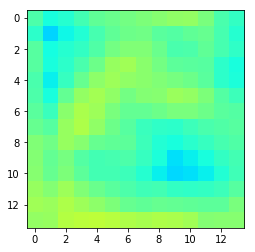

In [133]:
plt.imshow(output[0],cmap='jet',vmax=output.max(),vmin=output.min())
output[0,8:,8:]

In [134]:
output_n.sum(0)[0,8:,8:]

tensor([[-3.1314, -3.3613, -3.0061, -2.6747, -2.3586, -2.1651],
        [-3.2478, -3.9831, -3.7057, -3.3442, -2.7698, -2.4485],
        [-3.6718, -4.0880, -3.9885, -3.6865, -3.0888, -2.4666],
        [-2.4511, -2.7663, -2.8529, -2.7583, -2.5603, -2.0138],
        [-1.6389, -1.7266, -1.7911, -1.8945, -1.8706, -1.2641],
        [-0.0943, -0.2050, -0.3853, -1.0102, -0.9832, -0.9577]])

In [135]:
model.nonLinearLayers_p

tensor([0.1259, 0.2423], device='cuda:0')

In [136]:
inputs = input.cpu().squeeze(0).numpy()
output = output.numpy()
output_n = output_n.numpy()
target = target.numpy()
residual = np.abs(target - output)

Step by step going into val_linearity

In [137]:
x = input

In [138]:
Yn_length = torch.zeros(model.layers)
Yn = torch.zeros((model.layers, *model.output_size))

In [139]:
# record nonLinearLayersRecord
Y_sum = model.linear(0, x, torch.zeros_like(x)).cuda(model.gpu_id)
for i in range(1,model.layers):
    Y_sum = model._rec_nonLinear(i - 1, Y_sum)
    Y_sum = model.linear(i, x, Y_sum)
Y_sum = Y_sum.reshape(model.output_size).cpu()

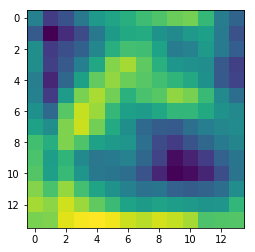

In [140]:
plt.imshow(Y_sum.data[0])

In [141]:
y0 = model.linearLayers_bn[2](x)
y1 = model.linearLayers_bn[1](x)
y2 = model.linearLayers_bn[0](x)

In [61]:
print(y0[0,0,:6,:6])
print(y1[0,0,:6,:6])
print(y2[0,0,:6,:6])

tensor([[ 0.0296, -0.0668, -0.1329, -0.1251, -0.0282,  0.0083],
        [-0.0965, -0.1818, -0.2893, -0.2760, -0.1757, -0.1467],
        [-0.0077, -0.0931, -0.1996, -0.2232, -0.2847, -0.1248],
        [ 0.1096, -0.0717, -0.1978, -0.2910, -0.0890,  0.1651],
        [-0.0127, -0.1508, -0.1572, -0.0495,  0.4586,  0.8550],
        [-0.1409, -0.2872, -0.1315,  0.2655,  1.0100,  1.3528]],
       device='cuda:0')
tensor([[ 0.0296, -0.0668, -0.1329, -0.1251, -0.0282,  0.0083],
        [-0.0965, -0.1818, -0.2893, -0.2760, -0.1757, -0.1467],
        [-0.0077, -0.0931, -0.1996, -0.2232, -0.2847, -0.1248],
        [ 0.1096, -0.0717, -0.1978, -0.2910, -0.0890,  0.1651],
        [-0.0127, -0.1508, -0.1572, -0.0495,  0.4586,  0.8550],
        [-0.1409, -0.2872, -0.1315,  0.2655,  1.0100,  1.3528]],
       device='cuda:0')
tensor([[ 0.0296, -0.0668, -0.1329, -0.1251, -0.0282,  0.0083],
        [-0.0965, -0.1818, -0.2893, -0.2760, -0.1757, -0.1467],
        [-0.0077, -0.0931, -0.1996, -0.2232, -0.2847, 

In [98]:
def vis(y, t, i, h=3,w=4,universal = True):
    cmap = 'jet'
    fig1, axes = plt.subplots(h,w,figsize=(10,10))

    im0 = axes[0][0].imshow(toPIL(val_dataset[i][0]))
    for k in range(1,h*w):
        if universal:
            axes[k//w][k%w].imshow(y[t[k-1]],cmap=cmap,vmax=y.max(), vmin=y.min())
        else:
            axes[k//w][k%w].imshow(y[t[k-1]],cmap=cmap)
    fig1.tight_layout()
    plt.show()

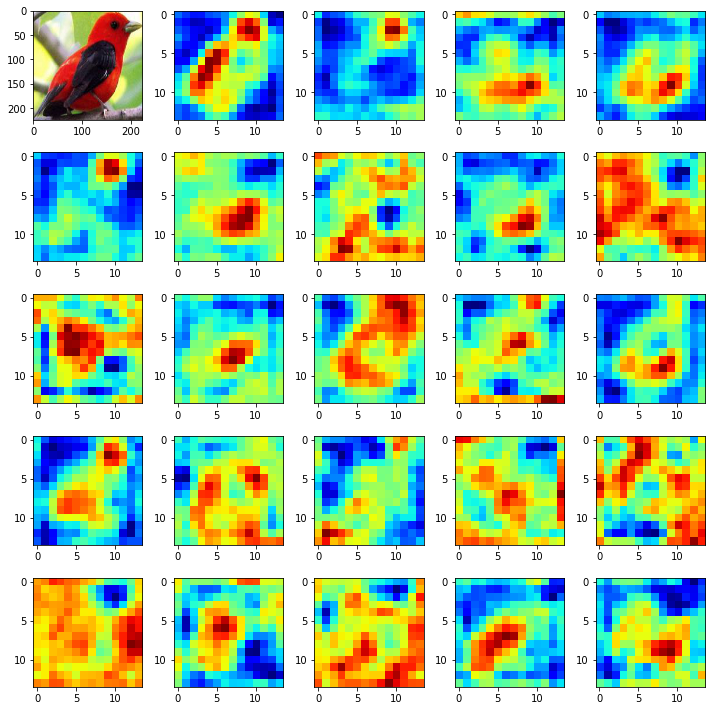

In [144]:
t = np.arange(11)*32
vis(y0.squeeze().data,np.arange(24)*16, 3994,5,5,0)

In [18]:
# record Yn
for n in range(model.layers):
    z = torch.zeros_like(x).cuda(model.gpu_id)
    out = z
    if n == model.layers - 1:
        out = model.linear(0, x, out)
    for i in range(1, model.layers):
        n_ = model.layers - i - 1
        if n == n_:
            out = model._yn_nonLinear(i - 1, out)
            out = model.linear(i, x, out)
        elif n > n_:
            out = model._yn_nonLinear(i - 1, out)
            out = model._yn_linear(i, out)
    Yn[n] = out.reshape(model.output_size).cpu()
    Yn_length[n] = torch.sum(Yn[n] ** 2) ** 0.5
Yn_contribution = Yn_length ** 2 / torch.sum(Yn_length ** 2)

return Y_sum, Yn, Yn_contribution, None

SyntaxError: unexpected EOF while parsing (<ipython-input-18-6f21c0975997>, line 1)

In [145]:
z = torch.zeros_like(x).cuda(model.gpu_id)
out = z

In [146]:
out = model._yn_nonLinear(0, out)
out[0,0,8:,8:]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<SliceBackward>)

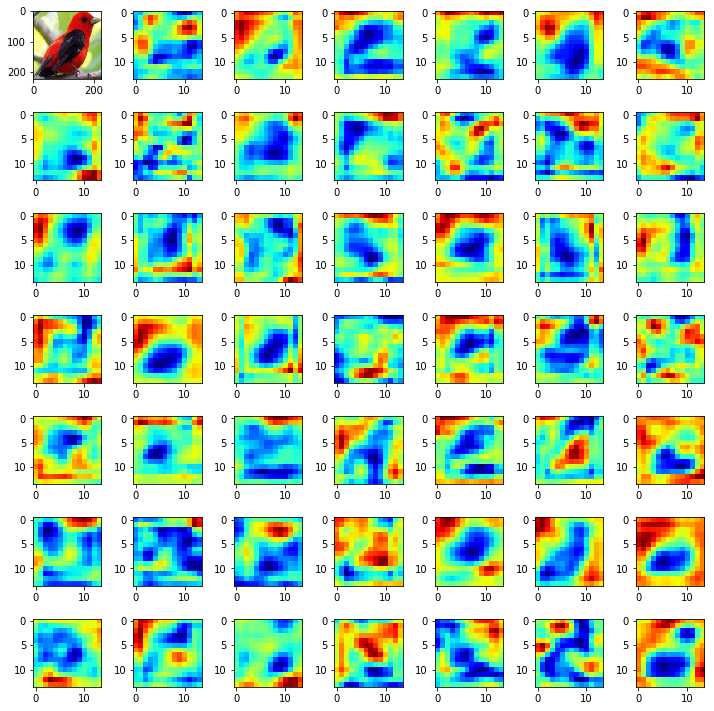

tensor([[ 0.1961, -0.9033, -2.4129, -3.8327, -2.3646, -0.3155],
        [-1.4650, -1.6329, -2.4151, -2.5162, -0.1881,  0.8595],
        [ 0.7989,  1.3485,  1.8301,  1.6902,  2.2321,  1.3456],
        [ 1.5017,  1.2267,  2.2745,  3.6133,  3.8593,  3.0617],
        [-0.3266, -0.4922,  0.1925, -0.4076,  0.2074,  0.0906],
        [ 0.4634,  0.1984, -0.5087, -1.7862, -1.2671, -0.3901]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [148]:
out1 = model.linear(1, x, out)
vis(out1.squeeze().data, np.arange(48)*8, 3994,7,7,0)
# plt.imshow(out1.squeeze().data.sum(0))
out1[0,0,8:,8:]

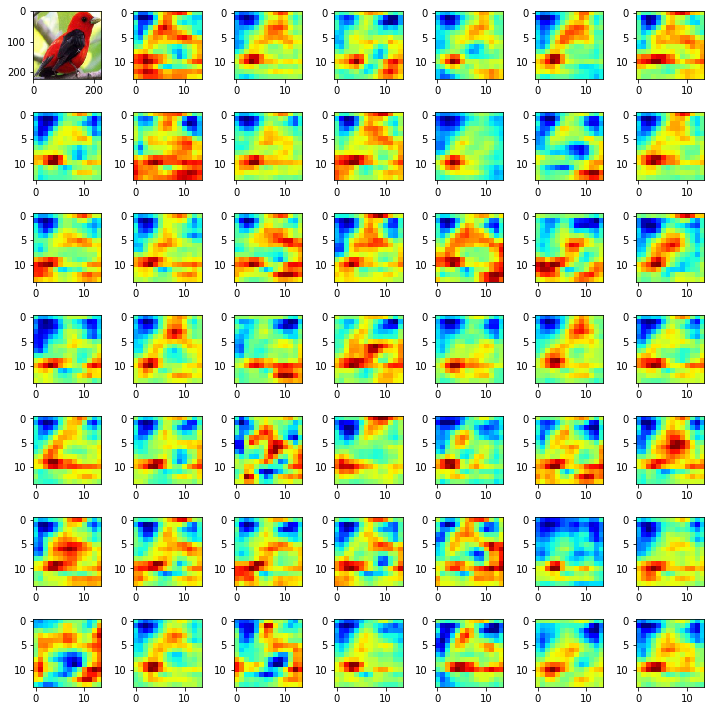

tensor([[-1.3850, -1.6335, -1.1270, -0.5395,  0.0027,  0.4092],
        [-1.0037, -1.7183, -1.2255, -0.5007,  0.2408,  0.5770],
        [-0.3990, -0.5173, -0.0494,  0.5035,  0.9792,  1.1189],
        [-0.9221, -0.9260, -0.7602, -0.5003, -0.2240,  0.0475],
        [ 0.6576,  0.7155,  0.7170,  0.6718,  0.5734,  0.7228],
        [ 0.7970,  0.7937,  0.7201,  0.2211,  0.2210,  0.1010]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [100]:
out2 = model.linear(2,x,z)
vis(out2.squeeze().data, np.arange(48)*8, 3994,7,7,0)
out2[0,0,8:,8:]

In [94]:
print(out1[:,233,:5,:5])
print(out1.max(), out1.min())

tensor([[[ 3.4172,  7.6608,  4.6474, 13.0301, 14.1503],
         [11.7702, 19.2588, 17.9438, 22.1251, 17.8242],
         [ 5.7957,  9.1042,  1.3552,  8.4728,  4.4084],
         [12.5708,  9.2727, -2.3578,  3.0261, -0.6135],
         [15.8352, 10.4083, -6.2000, -3.6349, -6.3972]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(166.2669, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-180.4779, device='cuda:0', grad_fn=<MinBackward1>)


In [95]:
y0[:,500,:5,:5]

tensor([[[-0.2052, -0.3756, -0.2682, -0.3034, -0.3513],
         [-0.2900, -0.5568, -0.4929, -0.4062, -0.5050],
         [-0.1305, -0.3795, -0.2356, -0.3476, -0.3494],
         [ 0.0035, -0.1134, -0.2198, -0.3163, -0.2415],
         [ 0.1039, -0.0656, -0.1691, -0.2171, -0.1176]]], device='cuda:0')

In [96]:
out1_bnc = out1 / model.nonLinearLayers_norm[1]

In [97]:
print(out1_bnc[:,233,:5,:5])
print(out1_bnc.max(), out1_bnc.min())


tensor([[[ 0.2253,  0.5051,  0.3064,  0.8592,  0.9330],
         [ 0.7761,  1.2699,  1.1832,  1.4589,  1.1753],
         [ 0.3822,  0.6003,  0.0894,  0.5587,  0.2907],
         [ 0.8289,  0.6114, -0.1555,  0.1995, -0.0405],
         [ 1.0441,  0.6863, -0.4088, -0.2397, -0.4218]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(4.9672, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.7519, device='cuda:0', grad_fn=<MinBackward1>)


In [36]:
out2 = model.linear(0,x,z)

In [38]:
print(out2[:,233,:5,:5])
print(out2.max(), out2.min())

tensor([[[ -2.0905, -10.3681, -10.5966,  -7.3341,  -5.6327],
         [ -6.1485, -13.9836, -15.5323, -13.9273, -13.4054],
         [ -5.2768, -13.9183, -13.6009, -11.4701, -10.7497],
         [ -4.9147, -13.3575,  -9.8965,  -5.1412,  -2.9388],
         [ -3.3763,  -9.9267,  -2.6566,   5.9011,   9.7699]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(139.7486, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-145.4371, device='cuda:0', grad_fn=<MinBackward1>)


In [37]:
out2_bnc0 = out2 / model.nonLinearLayers_norm[0]

In [39]:
out2_bnc0[:,233,:5,:5]

tensor([[[-0.1512, -0.7497, -0.7663, -0.5303, -0.4073],
         [-0.4446, -1.0112, -1.1232, -1.0071, -0.9694],
         [-0.3816, -1.0065, -0.9835, -0.8294, -0.7773],
         [-0.3554, -0.9659, -0.7156, -0.3718, -0.2125],
         [-0.2441, -0.7178, -0.1921,  0.4267,  0.7065]]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [40]:
out2_rl0 = out2_bnc0 * model.nonLinearLayersRecord[0]
out2_to1 = out2_rl0 * model.nonLinearLayers_p[0]

In [41]:
out2_conv1 = model.linearLayers_conv[1](out2_to1)

In [42]:
print(out2_conv1[:,233,:5,:5])
print(out2_conv1.max(), out2_conv1.min())


tensor([[[-52.4383, -54.3568, -77.4509, -64.6864, -66.9375],
         [-41.5731, -38.3238, -58.2921, -42.8055, -44.1545],
         [-48.7884, -42.1903, -63.1676, -43.6074, -45.4410],
         [-43.9224, -35.0686, -53.3720, -31.9931, -33.0600],
         [-50.1312, -40.3608, -59.5557, -35.7471, -35.9480]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(189.6842, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-197.4370, device='cuda:0', grad_fn=<MinBackward1>)


In [43]:
out2_bnc1 = out2_conv1 /  model.nonLinearLayers_norm[1]

In [44]:
print(out2_bnc1[:,233,:5,:5])
print(out2_bnc1.max(), out2_bnc1.min())

tensor([[[-0.6983, -0.7238, -1.0313, -0.8614, -0.8913],
         [-0.5536, -0.5103, -0.7762, -0.5700, -0.5880],
         [-0.6497, -0.5618, -0.8411, -0.5807, -0.6051],
         [-0.5849, -0.4670, -0.7107, -0.4260, -0.4402],
         [-0.6675, -0.5374, -0.7930, -0.4760, -0.4787]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(3.8346, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.8181, device='cuda:0', grad_fn=<MinBackward1>)


In [45]:
out_1_2 = out1_bnc + out2_bnc1

In [56]:
print(out_1_2[:,3,:14,:14])
print(out_1_2.max(), out_1_2.min(), out_1_2.mean())

tensor([[[-0.2590, -0.3484, -0.5157, -0.3319, -0.4823, -0.4839, -0.5328,
          -0.5068, -0.4601, -0.4539, -0.3555, -0.4052, -0.4022, -0.3029],
         [-0.5043, -0.6064, -0.7349, -0.5818, -0.7151, -0.7349, -0.8384,
          -0.8878, -0.9254, -0.9741, -0.8872, -0.8679, -0.7122, -0.4633],
         [-0.6068, -0.7659, -0.9607, -0.8906, -1.0555, -1.1226, -1.3058,
          -1.4510, -1.5812, -1.6557, -1.5127, -1.4173, -1.0596, -0.6918],
         [-0.5130, -0.7296, -0.9728, -0.9438, -1.1687, -1.3036, -1.5254,
          -1.6839, -1.8066, -1.8433, -1.5961, -1.4424, -1.1091, -0.7580],
         [-0.4864, -0.6958, -0.9216, -0.9248, -1.2156, -1.4071, -1.6037,
          -1.6981, -1.7401, -1.7163, -1.3873, -1.2531, -0.9611, -0.6836],
         [-0.4384, -0.6401, -0.8634, -0.8938, -1.1881, -1.3689, -1.5392,
          -1.6412, -1.6332, -1.5389, -1.1976, -1.1251, -0.8641, -0.6263],
         [-0.3858, -0.5787, -0.7925, -0.8346, -1.1183, -1.2796, -1.4403,
          -1.5355, -1.4961, -1.3670, -1.0149,

In [47]:
out1_c2 = out1_bnc * model.nonLinearLayersRecord[1] * model.nonLinearLayers_p[1]
out2_c2 = out2_bnc1 * model.nonLinearLayersRecord[1] * model.nonLinearLayers_p[1]

In [53]:
print(out2_c2[:,345,:14,:14])
print(out2_c2.max(), out2_c2.min())

tensor([[[-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.2372, -0.2928, -0.3349, -0.3201, -0.3249, -0.3118, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.3301],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000,

In [57]:
print(out1_c2[:,233,:5,:5])
print(out1_c2.max(), out1_c2.min())

tensor([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [-0., -0., -0., -0., -0.],
         [ 0., -0., -0., -0., -0.],
         [ 0., -0., -0., -0., -0.]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(1.8692, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-1.3726, device='cuda:0', grad_fn=<MinBackward1>)


In [58]:
(out1_c2+out2_c2).min()

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

In [59]:
nn.ReLU()(y0[:,233,:5,:5])

tensor([[[0.4133, 0.1693, 0.2887, 0.4521, 0.4167],
         [0.0000, 0.0000, 0.0000, 0.0084, 0.3133],
         [0.2291, 0.0000, 0.2325, 0.3964, 0.7354],
         [0.1960, 0.2296, 0.4561, 0.5175, 0.5697],
         [0.1528, 0.3062, 0.5027, 0.4447, 0.2720]]], device='cuda:0')

In [60]:
out_f0 = model.linearLayers_conv[2](y0)
out_f1 = model.linearLayers_conv[2](out1_c2)
out_f2 = model.linearLayers_conv[2](out2_c2)

In [61]:
print(out_f0[:,233,:5,:5])
print(out_f1[:,233,:5,:5])
print(out_f2[:,233,:5,:5])
print(out_f0.max())
print(out_f1.max())
print(out_f2.max())


tensor([[[-1.1895, -1.6890, -1.5484, -1.6595, -1.8679],
         [-0.5275, -0.9372, -0.7442, -0.9076, -1.1260],
         [ 0.5583,  0.3578,  0.3251, -0.0326, -0.2690],
         [ 0.8322,  0.8196,  0.6262,  0.0440,  0.0347],
         [ 0.4846,  0.5584,  0.7214,  0.5656,  0.8115]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[[-0.4110, -0.3306,  0.0217, -0.1839, -0.1904],
         [-0.9764, -1.0243, -0.9267, -0.8252, -0.8515],
         [-1.5992, -1.6792, -1.3989, -1.1712, -0.9961],
         [-1.7480, -2.0234, -1.6306, -1.3739, -1.0081],
         [-1.4588, -1.7532, -1.3239, -1.5042, -1.5077]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[[-1.5347, -2.0026, -1.9518, -1.6951, -2.0864],
         [-1.5892, -2.1941, -2.0532, -2.1292, -2.3914],
         [-1.3256, -1.8949, -1.8407, -1.7940, -1.8831],
         [-1.2892, -1.5184, -1.4363, -1.2321, -1.3671],
         [-1.2793, -1.2230, -1.2996, -0.9670, -1.0478]]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor(

In [62]:
model.linearLayers_conv[2].weight.norm()

tensor(82.5513, device='cuda:0', grad_fn=<NormBackward0>)

In [69]:
i

2

torch.Size([512, 512, 5, 5])
tensor([[[-0.0103, -0.0133, -0.0160, -0.0129,  0.0264],
         [-0.0153, -0.0102, -0.0024, -0.0210, -0.0147],
         [ 0.0047,  0.0117,  0.0307,  0.0234,  0.0290],
         [-0.0014,  0.0319,  0.0474,  0.0177,  0.0239],
         [-0.0821, -0.0930, -0.0686, -0.0852, -0.0507]],

        [[ 0.0096, -0.0041, -0.0138, -0.0178,  0.0066],
         [ 0.0105,  0.0047,  0.0173, -0.0015,  0.0076],
         [ 0.0050, -0.0081,  0.0205, -0.0261,  0.0049],
         [ 0.0348,  0.0591,  0.0536,  0.0363, -0.0022],
         [ 0.0011,  0.0635,  0.0293,  0.0055, -0.0057]],

        [[-0.0217, -0.0244, -0.0031, -0.0087, -0.0160],
         [-0.0417, -0.0323, -0.0295, -0.0183, -0.0081],
         [-0.0031, -0.0426, -0.0349, -0.0546, -0.0260],
         [ 0.0046, -0.0051, -0.0152, -0.0200, -0.0075],
         [ 0.0789,  0.0699,  0.0631,  0.0491,  0.0322]],

        [[ 0.0044, -0.0187, -0.0079, -0.0328, -0.0402],
         [-0.0273,  0.0129,  0.0001, -0.0251, -0.0135],
         [-0.

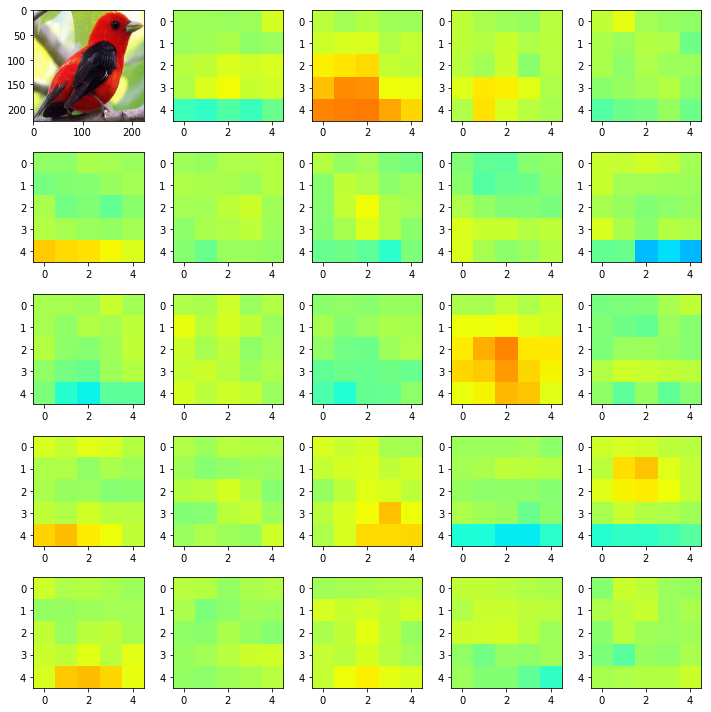

In [82]:
print(model.linearLayers_conv[2].weight.shape)
print(model.linearLayers_conv[2].weight[0,0:129:32,:,:])
vis(model.linearLayers_conv[2].weight[0].data,np.arange(24)*16,3994,5,5)

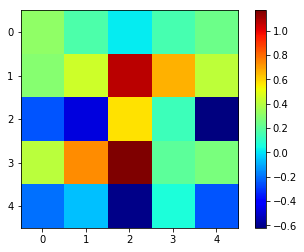

In [102]:
plt.imshow(model.linearLayers_conv[2].weight[1].data.sum(0), cmap='jet')
plt.colorbar()

In [150]:
dm = torch.ones((1,512,14,14)).cuda(0)

In [151]:
dm_out = model.linearLayers_conv[1](dm)

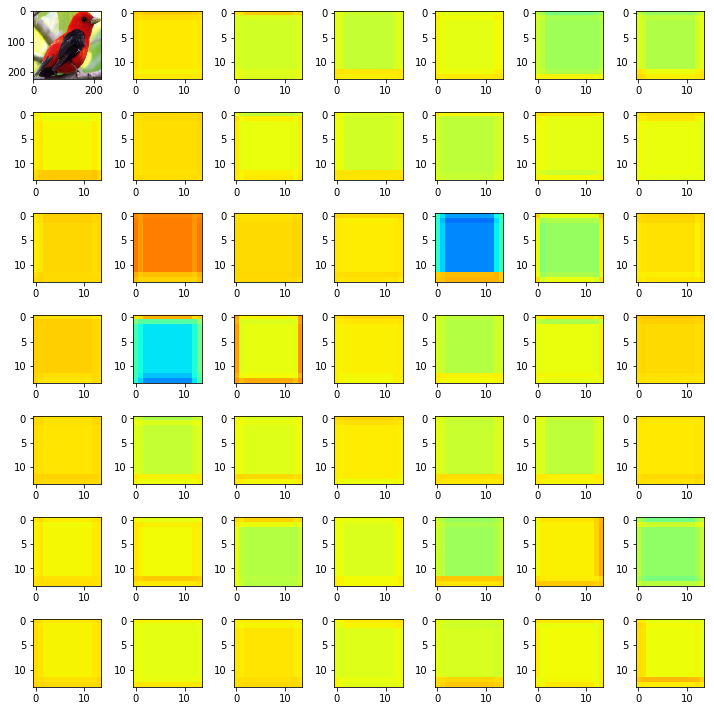

In [152]:
# plt.imshow(dm_out.squeeze().data[2],cmap='jet')
# plt.colorbar()
vis(dm_out.squeeze().data, np.arange(48)*8, 3994,7,7,1)

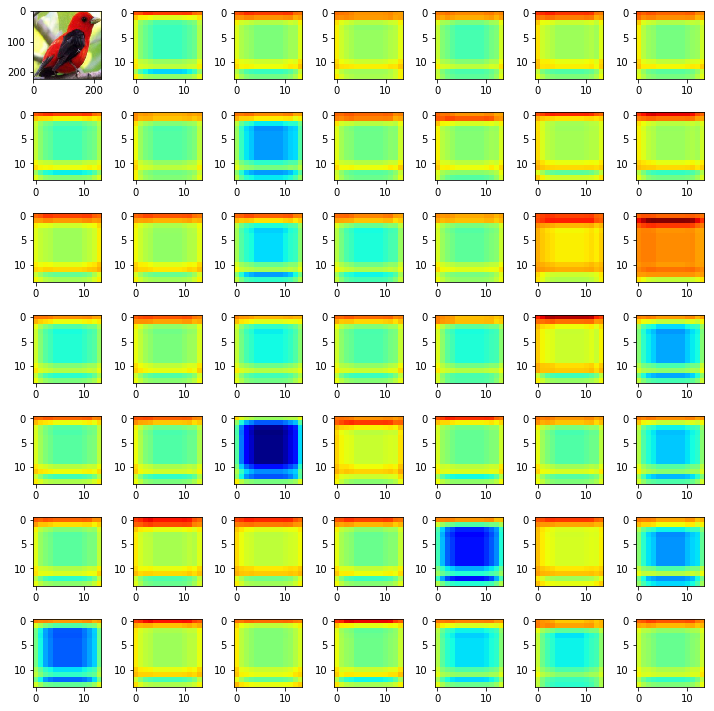

In [153]:
dm_out2 = model.linearLayers_conv[2](dm_out)
vis(dm_out2.squeeze().data, np.arange(48)*8, 3994,7,7,1)

In [154]:
model.training

False

In [17]:
model.nonLinearLayers_norm[1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [6]:
from linearTest_sigmoidP import LinearTester

In [12]:
model = LinearTester(input_size,output_size, gpu_id= gpu)


In [18]:
model.nonLinearLayers_norm

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
model.state_dict()

OrderedDict([('nonLinearLayers_p_pre', tensor([0., 0.])),
             ('nonLinearLayers_norm', tensor([[1., 1., 1.,  ..., 1., 1., 1.],
                      [0., 0., 0.,  ..., 0., 0., 0.]])),
             ('linearLayers_bn.0.running_mean',
              tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       